In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# To check the GPU using in Colab for faster computation
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shape
print(f"Training Data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data: {x_test.shape}, Labels: {y_test.shape}")


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training Data: (50000, 32, 32, 3), Labels: (50000, 1)
Testing Data: (10000, 32, 32, 3), Labels: (10000, 1)


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

def residual_block(x, filters, kernel_size=3, stride=1):
    """Defines a residual block with a shortcut connection"""
    shortcut = x  # Identity shortcut connection

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # If input and output dimensions differ, use a 1x1 convolution to match dimensions
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut connection
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x


In [ ]:
def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)

    # ResNet Layers (Stack of Residual Blocks)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global Average Pooling & Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, x)
    return model

# Create the model
resnet_model = build_resnet()
resnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ add_1[0][0]            │
├──────────────────────

 Total params: 11,188,362 (42.68 MB)

 Trainable params: 11,178,762 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = resnet_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - accuracy: 0.4423 - loss: 1.6914 - val_accuracy: 0.5855 - val_loss: 1.2324
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.7242 - loss: 0.7837 - val_accuracy: 0.7304 - val_loss: 0.7790
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8053 - loss: 0.5599 - val_accuracy: 0.7655 - val_loss: 0.7112
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8493 - loss: 0.4328 - val_accuracy: 0.7665 - val_loss: 0.7238
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8821 - loss: 0.3407 - val_accuracy: 0.7914 - val_loss: 0.6582
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9164 - loss: 0.2460 - val_accuracy: 0.8087 - val_loss: 0.6271
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9365 - loss: 0.1781 - val_accuracy: 0.8023 - val_loss: 0.6452
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9509 - loss: 0.1426 - 

In [ ]:
test_loss, test_acc = resnet_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7828 - loss: 0.8726
Test Accuracy: 0.78


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


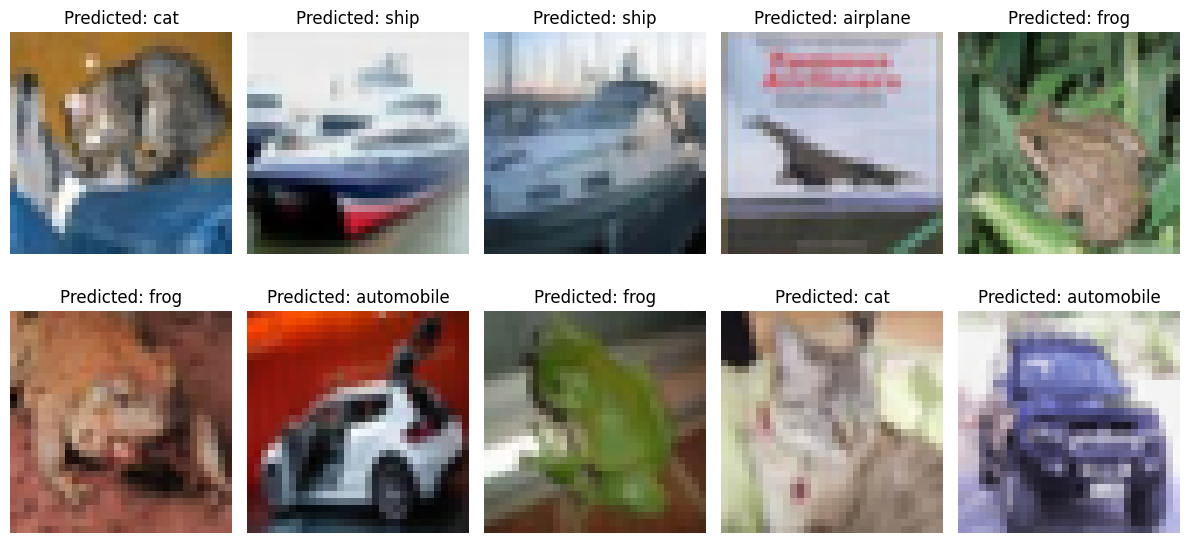

In [ ]:
class_labels = ["airplane", "automobile", "bird", "cat", "deer",
                "dog", "frog", "horse", "ship", "truck"]

# Get predictions for the first 5 test images
predictions = resnet_model.predict(x_test[:10])
predicted_labels = np.argmax(predictions, axis=1)

# Display the images with their predicted labels
# Create a 2-row, 5-column grid
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(x_test[i])
    ax.set_title(f"Predicted: {class_labels[predicted_labels[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()